### Tutorial_Find_Eigenvalues_Kerr_Slice.ipynb

Victor Zhang and Daniel Pook-Kolb

# Summary: 

Jupyter Notebook Tutorial demonstrating how to use MOTSFinder with the Kerr metric (in Kerr-Schild form) to calculate:
- expansion at a point on a surface, or along a surface (see [3] for definitions)
- spectrum of the stability operator defined in [1] for a MOTS 
    
# <span style="color:red">Important:</span>
- You should always perform convergence tests with different resolutions for the finite difference method in taking derivatives and pseudo-spectral method for curves. This will help you estimate the accuracy of your numerical results. To avoid redundancy, convergence tests are not included below.
    - The parameter ```res``` denotes the inverse finite difference step size for taking derivatives. Change this to vary the resolution for the finite difference method.
    - The parameter ```num``` denotes the number of basis functions to use when expanding a function in a Fourier-like basis (i.e. into Sines, Cosines, Chebyshev polynomials, etc.). Change this to vary the resolution of the pseudo-spectral method. 
    
# Other Notes:
- MOTSFinder assumes axisymmetry; each 2D plot drawn is the $xz$ plane



### References: 

[1] Andersson, Lars, Marc Mars, and Walter Simon. 
    "Stability of marginally outer trapped surfaces and existence of marginally outer trapped tubes." 
    arXiv preprint arXiv:0704.2889 (2007).
 
[2] Visser, Matt. "The Kerr Spacetime: A brief introduction" 
    https://arxiv.org/pdf/0706.0622.pdf

[3] D. Pook-Kolb, O. Birnholtz, B. Krishnan and E. Schnetter "Existence and stability of marginally trapped surfaces in black-hole spacetimes." Physical Review D 99.6 (2019): 064005.

In [1]:
%matplotlib inline
import sys
import os

# Change the path to where the code is located.
sys.path.append(os.path.expanduser('~/src/motsfinder')) 

import numpy as np
import matplotlib.pyplot as plt
from motsfinder.ipyutils import reload_all
from motsfinder.utils import save_to_file, load_from_file
exec(reload_all())


# Creating a Kerr Slice 

In [2]:
# Parameters for the Kerr metric
M = 1.0
a = 0.0 # can take values from a = 0.0 to a = M

# r_plus is a convenient reference shape (see below); note this is the radial coordinate of the event horizon
r_plus = M + np.sqrt(M * M - a * a)


# The inverse finite difference step size for taking derivatives
res = 200

# Define a Kerr slice (gKS contains info on the 3-metric, shift, lapse, and extrinsic curvature of the slice)
gKS = KerrKSSlice(M = M, a = a)

### Discretize the metric ###

# Creating the discretized metric, g, for the Kerr slice, gKS, defined above
g = FDDerivMetric(
    metric = gKS, # metric to discretize
    res = res, # resolution of finite difference method
    fd_order = 6 # order of the finite difference method
)


# Finding a MOTS Numerically 

Use the ```find_mots()``` method to search for the MOTS.

Quick summary of various parameters (see documentation for more detailed explanations):
- ```'discrete8'``` is a preset choosing suitable default values for many settings we do not specify here

- ```metric``` is the discretized metric to use

- ```hname``` is the name of the MOTS under consideration

- ```num``` is the resolution of the pseudo-spectral method for curves; indicates how many basis functions to take when
  approximating curve; here we take the first 30 basis functions
  
- ```atol`` is the tolerance for the residual expansion
  
- ```reparam = False``` takes the reference curve without further transformation.

- ```c_ref``` is the reference curve/shape. Can be a float (which represents a circle in the $xz$ plane, or a coordinate 
  sphere after taking axisymmetry into account), or any curve object (which can be converted to a parametric 
  curve). Here we take the coordinate sphere of radius ```r_plus``` (which is the exact MOTS for $a = 0$, but not for 
  non zero $a$)
  
- ```verbose``` should be ```True``` if you want to see status information printed during the MOTS search
  
- ```plot_steps``` should be ```True``` if you want to see the steps in finding the MOTS

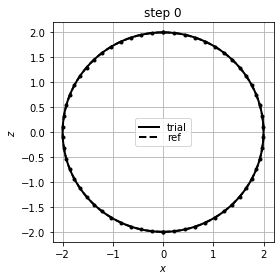

01: max error at 30 collocation points: 3.547162563677375e-14
  Accurate error = 3.68039e-14 <= 1e-12 at resolution 30


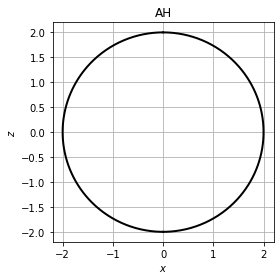

In [3]:
c_AH = find_mots(
    cfg = GeneralMotsConfig.preset(
        'discrete8', 
        metric = g, 
        hname = 'AH', 
        num = 30, 
        atol = 1e-12,
        reparam = False,
        c_ref = r_plus, # Note: depending on your choice of c_ref, a MOTS can be easily or not as easily found.
                        # In the latter case, refine your reference shape.
        verbose = True,
        plot_steps = True,
    )
)

# Plot the MOTS after found
c_AH.plot(title = r"AH")


# Finding a MOTS knowing a priori the Exact Position

If desired, one can specify the exact (analytical) location of the MOTS. 
As an example, we do so below for the Kerr case (the event horizon is the MOTS for a single Kerr black hole).

Below curve taken from eq. (126) of [2]. See NOTES section for discussion of ParametricCurve object.

Max violation at given points: 7.061018436615996e-14


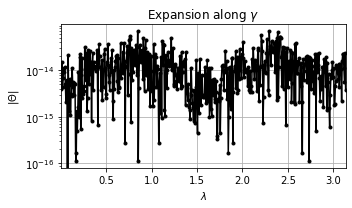

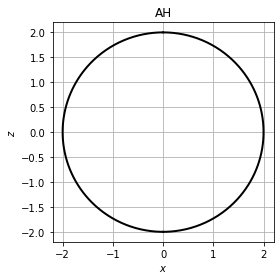

In [4]:
# Parametric curve for the MOTS, or event horizon in this case
c = ParametricCurve( # on x-z plane (due to axisymmetry)
    SineSeries([np.sqrt(2 * M * r_plus), 0]), # x component function
    CosineSeries([0, r_plus])
)

# Converts the parametric curve for the MOTS into a RefParamCurve object, which is an ExpansionCurve object,
# for which the expansion is defined. See documentation for class hierarchy and more details.
c_AH = RefParamCurve.from_curve(c, num=100, metric=g)

# Plot the expansion (of the outgoing null) of the curve as a function of the parameter parametrizing the curve. 
# For a MOTS, the expansion should be 0, up to numerical noise. 
c_AH.plot_expansion()

# Plot the MOTS
c_AH.plot(title = r"AH")


# Calculate the spectrum of the stability operator of the curve 

By default, the stability operator of [1] is calculated with respect to the normal to the MOTS in the slice. 

## Quick Summary of parameters:

- ```full_output``` should be ```True``` if you want to return all the eigenvalues calculated, in addition to the principal 
  eigenvalue. Setting ```full_output = False``` returns only the principal eigenvalue 

- ```num``` is the resolution of the pseudospectral method; here, it specifices the number of basis functions to use to
  represent eigenfunctions when calculating the eigenvalues. Note that eigenvalues with ```l``` (12th letter of the 
  English alphabet, lowercase) close to ```num``` lose accuracy because of increasing number of oscillations in eigenfunctions. 

See documentation for more details (changing vector which the stability operator is calculated w.r.t, 
additional parameters, etc.). 

In [ ]:
principal, spectrum = c_AH.stability_parameter(full_output = True, num = 100)

In [ ]:
# Principal eigenvalue
print(principal)

# Entire Spectrum 
print(spectrum)

# Saving a single spectrum for future use

In [ ]:
# It is suggested that you use a .npy file to save the spectrum
stabilityAFileNPYName = 'example_spectrum.npy'

# Saves the spectrum to the specified file. Note that overwrite = True will overwrite
# an existing file. If False and the file exists, a RuntimeError will be thrown. 
# See documentation for more details. 
save_to_file(stabilityAFileNPYName, spectrum, overwrite = True)    


# Saving multiple spectra for future use

It may happen that you want to calculate the spectrum for various parameters, and ideally would want to execute such a task in a ```for``` loop of sorts. If you want to save the spectrum for each iteration in the same file, the above method for saving a spectrum would not work; it would overwrite the previous spectrum each time. The workaround is to construct an array of spectrum, and append the new spectrum to the array and save the array each time (see below). 

Of course, if you want to save each spectrum in a different file, the method for saving a single spectrum works. 

In [ ]:
# Array to hold the spectra from different iterations
stabilityData = []

for i in range(start,end):
    
    # ... your code before calculating the spectrum ... 
    
    principal, spectrum = c_AH.stability_parameter(full_output = True, num = 100)

    # Appending the spectrum to the array #
    stabilityData.append(spectrum)
    
    # Saving the entire array to the specified file
    save_to_file(stabilityAFileNPYName, stabilityData, overwrite = True)    


# Reading/Loading the saved spectrum from a file

The below method works for a file where an array of spectra are saved; use 

```python
     spec = load_from_file(stabilityAFileNPYName)[0]
```

to capture the contents of the file. The ```[0]``` at the end of the ```python load_from_file()``` call is needed so that to access the 1st, 2nd, etc. spectrum that is saved, one can simply use ```spec[0]```, ```spec[1]```, etc., respectively. Otherwise, one needs to use the more clumsy notation ```spec[0][0]```, ```spec[0][1]```, etc., respectively.

In [ ]:
### Read from the specified file
spec = load_from_file(stabilityAFileNPYName)

# Print entire contents
print(spec)

# Get a specific l and m value (WLOG, getting the l=2 and m = 2 eigenvalue):
print(spec.get(l=2, m=1))



# NOTES

## (1) Defining a ParametricCurve object:

ParametricCurve can be used to define a parametrized curve on the $xz$ plane only (see documentation 
for full list of arguments); recall that MOTSFinder assumes axisymmetry.

One can use the built in polynomials such as sine and cosine to define curves, or define functions. The question of differentiability of user-defined functions is not an issue, because MOTSFinder will decompose the function into a sum of Chebyshev polynomials. However, one must make sure that the number of Chebyshev polynomials used in the decomposition is sufficient to capture the function to the desired accuracy by changing the parameter ```num```.

Below, we define the parametric curve: $\gamma(t) = (t, |t-1|)$ for parameter $t$. The domain for the parameter is $[0, \pi]$, but since we assume axisymmetry, the curve is mirrored across the $z$-axis. This can be prevented with ```paramCurve.plot(copy_x = False)```. The domain of the parameter cannot be changed unless you go into the source code and change it, so if you would like to reparameterize the curve, you must do so through a coordinate transform so that your parameter has domain $[0,\pi]$. 

Note that we set ```num = 100``` to capture the absolute value character of the function. Numerically, the function is still differentiable, since it is numerically represented as a finite sum of Chebyshev polynomials, and the latter are differentiable.

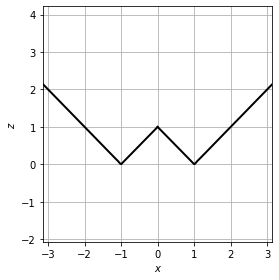

Max violation at given points: 138.66959752922668


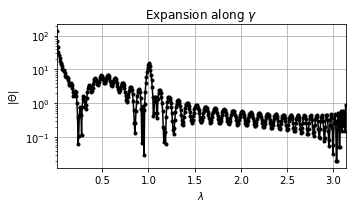

In [5]:
paramCurve = ParametricCurve.from_functions( 
        x=lambda t: t, z=lambda t: abs(t-1), num=100
)

# Plotting the user-defined parametric curve
paramCurve.plot()

# Converting to a Reference Curve with an associated metric
c_AH = RefParamCurve.from_curve(paramCurve, num=100, metric=g)

# Calculating the expansion at points on the curve 
c_AH.plot_expansion()